# Residual population stratification in GWAS

::: {.callout-note title="Important notes for this notebook" icon=false}

## Learning outcomes

- Identify potential population stratification in our GWAS output. 

## How to make this notebook work

* In this notebook, we will use both `R` and `bash command line` programming languages. Remember to **change the kernel** whenever you transition from one language to the other (`Kernel --> Change Kernel`) indicated by the languages' images. We will first run `Bash` commands.  
  
<img src="Images/bash.png" alt="Bash" width="80"> Choose the Bash kernel
 
:::

As we have discussed, it is important to remove population structure, as residual population stratification, as shown by [@sohail2019polygenic], can be detected in published GWAS. This can lead to biased effect size estimates, impacting polygenic risk scores (PRS) and other downstream analyses.

### Correlation between PC loadings and effect sizes
We followed a similar approach from [@sohail2019polygenic] to examine GWAS stratification along different PCA axes of population structure. We began by performing a PCA on the genotype data from the 1000 Genomes Project used in the previous notebook. Then, we computed the correlation between the first 10 PCA loadings and the effect size estimates from the GWAS conducted on the Hapmap data. We visualized these PC-specific correlations to explore patterns of stratification along different axes of genetic variation. Additionally, it would be very useful to consider allele frequency differences across different populations when analyzing such stratification.

We use PLINK to get the PC loadings using the `--pca var-wts` as follows: 

In [1]:
plink --bfile Results/GWAS4/1kG_MDS6 --pca 10 var-wts --out Results/GWAS4/PCA_1kg --silent

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

Now we will plot the correlation between the loadings and the effect sizes for both GWAS results from GWAS5. 

### A. Binary trait `--assoc` test

PC1           PC2           PC3           PC4           PC5 
-0.0132296407  0.0148094130  0.0001087109  0.0128764323 -0.0126458446 
          PC6           PC7           PC8           PC9          PC10 
-0.0318036207 -0.0118702516  0.0426472424 -0.0080939031  0.0915926824

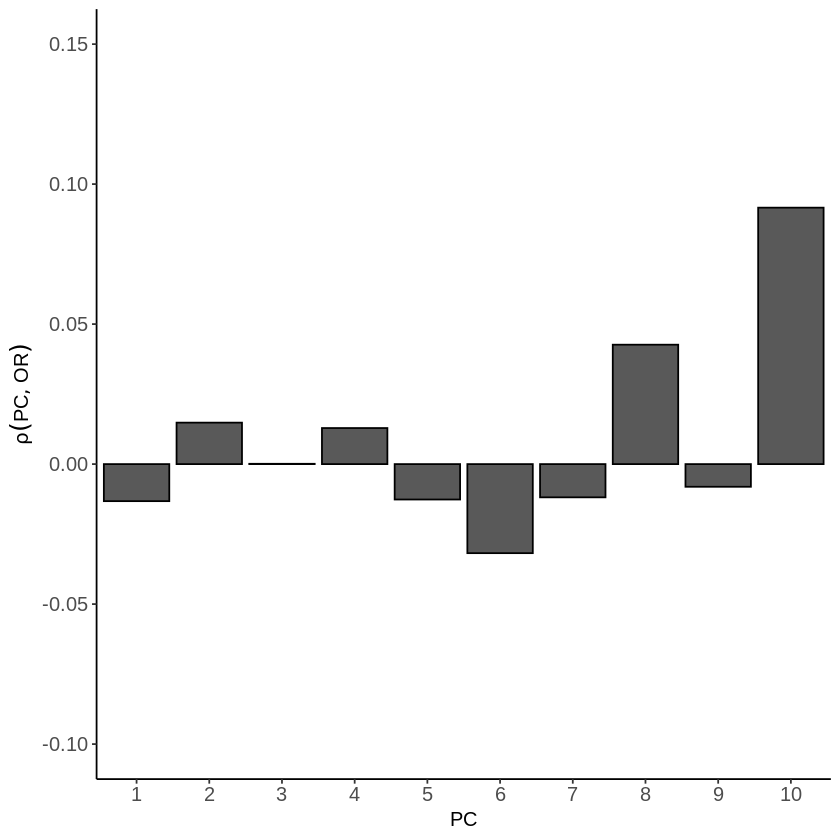

In [88]:
library(ggplot2)

# load the data 
results_as <- read.table("Results/GWAS5/assoc_results.assoc", head=TRUE)
data <- read.table(file="Results/GWAS4/PCA_1kg.eigenvec.var",header=FALSE)
colnames(data) <- c("CHROM", "ID", "a1", "a2", 
                    paste0("PC", 1:10))  # PC1 to PC10
# merge data 
merged_tab <- merge(results_as, data, by=2)
# compute correlations 
correlations <- apply(merged_tab[, 14:23], 2, function(x) cor(merged_tab$OR, x, method="pearson", use="complete.obs"))
correlations
dataCor <- data.frame(
  pc = 1:10,
  corr = correlations)


ggplot(as.data.frame(dataCor), aes(pc, corr)) +
    ylab(expression(rho(PC, OR))) +
    geom_bar(stat='identity', position='dodge', col='black')+
    xlab('PC') + 
    ylim(c(-0.1,0.15)) +
    scale_x_continuous(breaks=seq(1,10,1), expand=c(0,0.1))+
    theme(panel.grid.minor=element_blank(), panel.background = element_blank(),
            axis.line = element_line(), axis.text= element_text(size=12),
          axis.title= element_text(size=12))


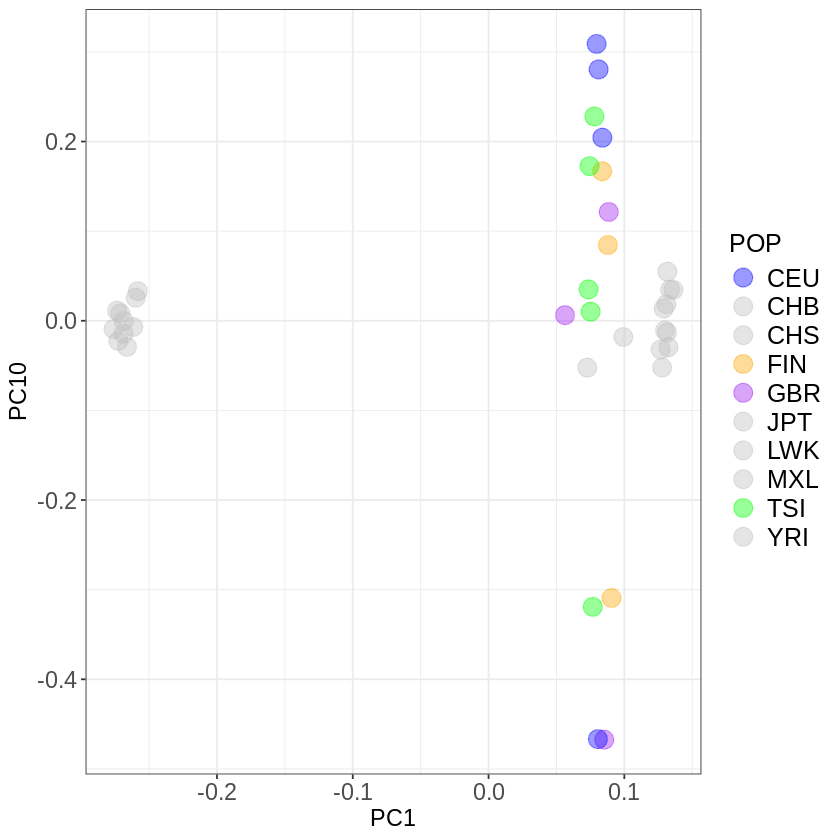

In [95]:
#eigen <- read.table(file="Results/GWAS4/PCA_1kg.eigenvec", header=F) 
#colnames(eigen) <-  c("FID", "IID", paste0("PC", 1:10))

pop <- read.table(file="Results/GWAS4/popfile.txt",header=TRUE)
df <- merge(eigen,pop,by=c("FID","IID"))
sex <- read.table("./Data/EUR.cov", header=T)

# Metapopulation information for the population in the 1000GP dataset
superpop <- c(
  "JPT" = "ASN",
  "ASW" = "AFR",
  "CEU" = "EUR",
  "CHB" = "ASN",
  "CHD" = "ASN",
  "YRI" = "AFR",
  "LWK" = "AFR",
  "TSI" = "EUR",
  "MXL" = "AMR",
  "GBR" = "EUR",
  "FIN" = "EUR",
  "CHS" = "ASN",
  "PUR" = "AMR")

# add metapopulation and assign cols  
df$SUPERPOP <- superpop[df$POP]
eur_col <- c("CEU" = "blue", "TSI" = "green", "GBR" = "purple", "FIN" = "orange")
all_cols <- setNames(ifelse(superpop == "EUR", eur_col[names(superpop)], "grey"), names(superpop))                  
df$color <- all_cols[df$POP]


ggplot(df, aes(PC1, PC10,color=POP)) + 
    geom_point(size=5, alpha=.4) +
    theme_bw() +
    scale_color_manual(values = all_cols) +
    theme(axis.title = element_text(size = 14), legend.text = element_text(size = 15), 
        axis.text = element_text(size = 14), legend.title=element_text(size=15))
  